# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

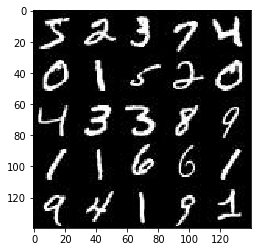

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

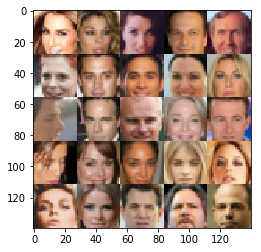

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    ins = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs")
    zs = tf.placeholder(tf.float32, shape=(None, z_dim), name="Z")
    lr = tf.placeholder(tf.float32, shape=())
    return ins, zs, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [51]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Radfort et. al, 2015
    init = tf.random_normal_initializer(mean=0, stddev=0.02)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding="same", kernel_initializer=init)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=5, strides=2, padding="same", kernel_initializer=init)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, filters=256, kernel_size=5, strides=2, padding="same", kernel_initializer=init)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        flat = tf.reshape(conv2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=init)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [44]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Why not pass it as argument? >=(
    reuse = not is_train
    
    # Radfort et. al, 2015
    init = tf.random_normal_initializer(mean=0, stddev=0.02)
    
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*256, kernel_initializer=init)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.relu(x1) # also Radfort et. al, 2015
        
        convt1 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=2, padding='same', kernel_initializer=init)
        convt1 = tf.layers.batch_normalization(convt1, training=is_train)
#         convt1 = tf.maximum(alpha * convt1, convt1)
        convt1 = tf.nn.relu(convt1)
        
        convt2 = tf.layers.conv2d_transpose(convt1, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=init)
        convt2 = tf.layers.batch_normalization(convt2, training=is_train)
#         convt2 = tf.maximum(alpha * convt2, convt2)
        convt2 = tf.nn.relu(convt2)
        
        logits = tf.layers.conv2d_transpose(convt2, filters=out_channel_dim, kernel_size=3, strides=1, padding='same', kernel_initializer=init)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Added alpha as fn parameter for easier hyperparameter tuning
    g = generator(input_z, out_channel_dim, is_train=True, alpha=0.1) # Generator `not is_train` used for setting reuse to false
    d_real, d_logits_real = discriminator(input_real, reuse=False, alpha=0.1)
    d_fake, d_logits_fake = discriminator(g, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real)*(1-0.1))) # smoothing
    
    
    return (d_loss_fake + d_loss_real), g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 30
    show_every = 300
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 0.9332
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.0141
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.0628
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.2396
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.4237


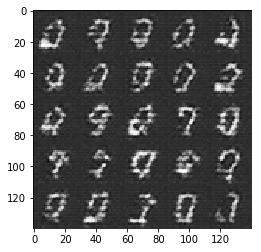

Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.2618
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.7661
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.4526
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.3920
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 1.6042
Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 1.9682
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.7773... Generator Loss: 1.3008


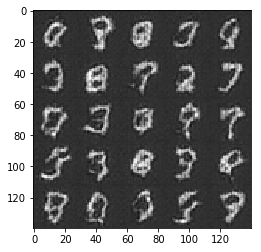

Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 1.4784
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.3728
Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 1.6600
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.6363
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 1.6776
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 1.5373
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.3452
Epoch 1/2... Discriminator Loss: 1.1488... Generator Loss: 1.7575
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 1.5130


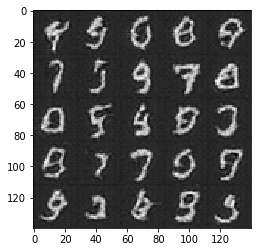

Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.5036
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 2.7316
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.2220
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.5654
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.4487
Epoch 2/2... Discriminator Loss: 0.7455... Generator Loss: 1.6180


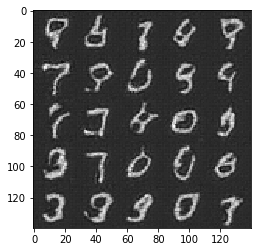

Epoch 2/2... Discriminator Loss: 0.9344... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.3646
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.3024
Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 1.6917
Epoch 2/2... Discriminator Loss: 0.7291... Generator Loss: 1.5729
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.4686
Epoch 2/2... Discriminator Loss: 3.2457... Generator Loss: 1.8851
Epoch 2/2... Discriminator Loss: 0.7842... Generator Loss: 1.4194
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.3401


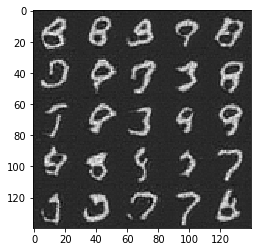

Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 0.9767
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 1.4240
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.2843
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.5834
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.3943
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0785


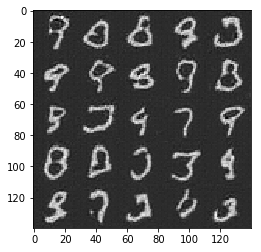

Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 2.1650
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.1718


In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.9814
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.4574
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.0850


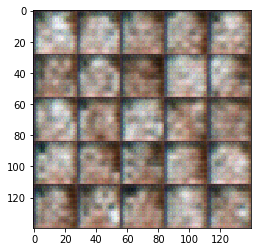

Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.2294
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.4582


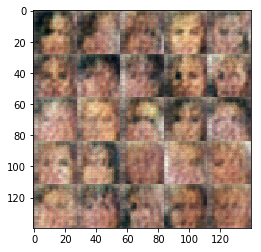

Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.8233
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.7785


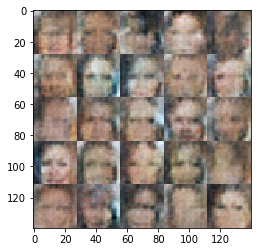

Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8501
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.7494
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.9151
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0558


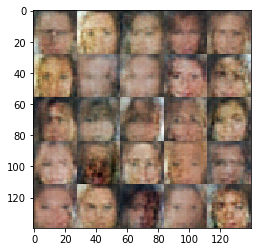

Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.8660


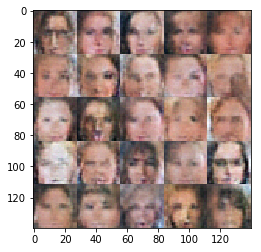

Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.1930... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.7948


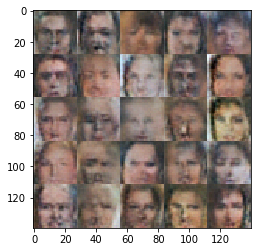

Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.7913


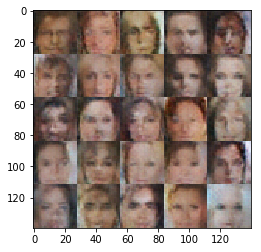

Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 1.1395
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 1.3318


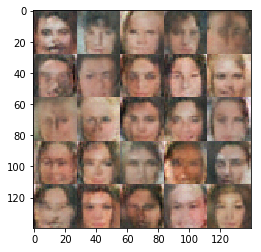

Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.8778


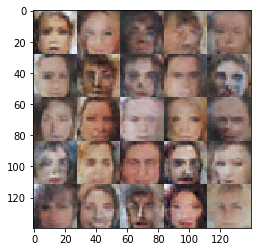

Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.3403... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.7858


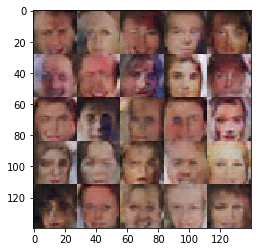

Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.7676


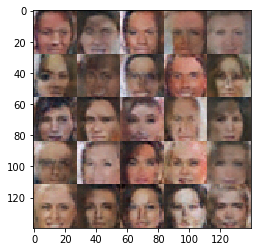

Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.8203
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 0.8707
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.7824


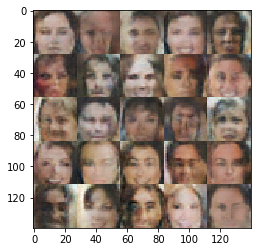

Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.8525
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.8478
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.9017


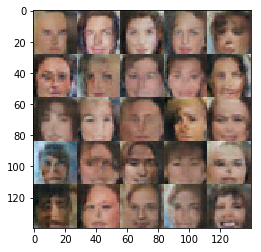

Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.8259


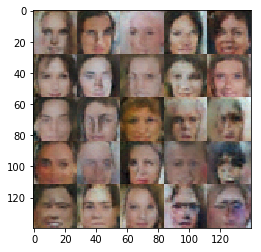

Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.8832
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.7630
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.7774
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.7903


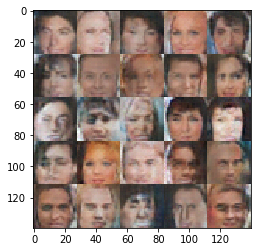

Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.7931


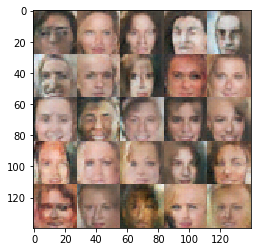

Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.8197


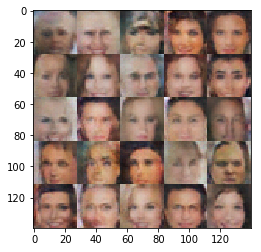

Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.7616
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.7806
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.2139


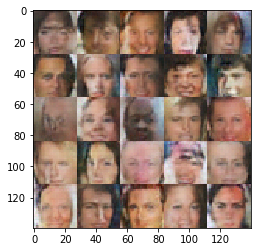

Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.8816
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.8541
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.7385


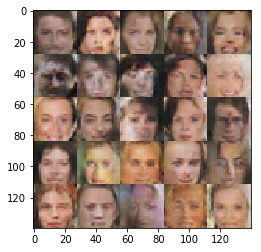

Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.8118
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.7890


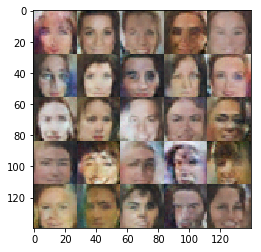

Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.7693


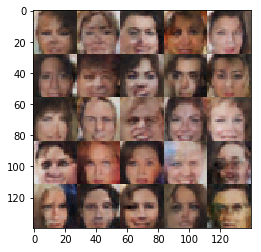

Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.7494


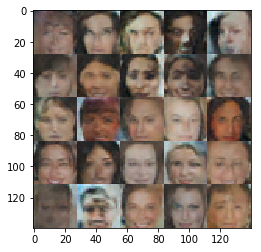

Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.7839


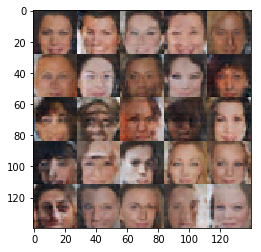

Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.4234... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.7513


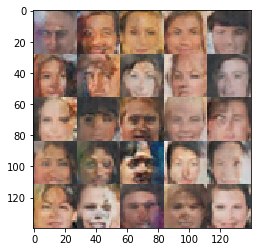

Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.7721
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 0.7677


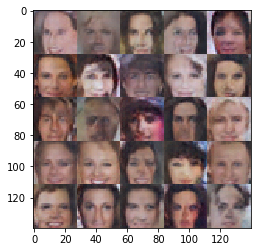

Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.8696
Epoch 2/2... Discriminator Loss: 1.3989... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.8088


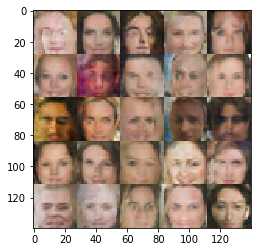

Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.8312
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.8301


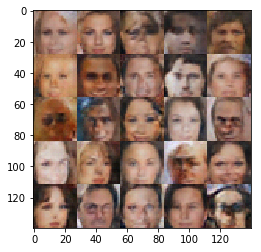

Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.3481... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.7521


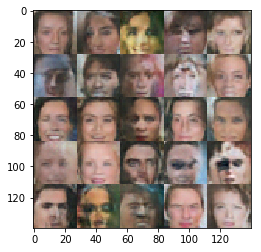

Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 0.7547


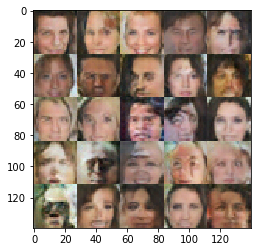

Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.7321


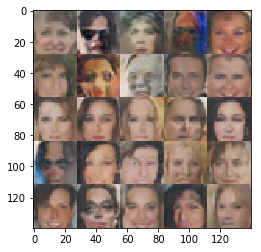

Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.4045... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.8730


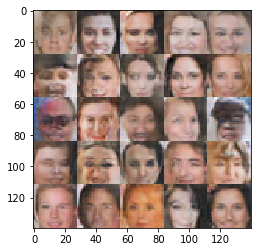

Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.7487
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.3973... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.8109


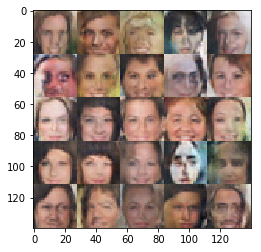

Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.7759


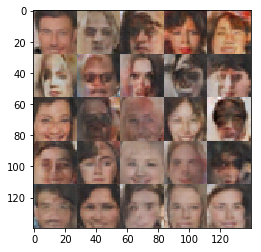

Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.4321... Generator Loss: 0.7184


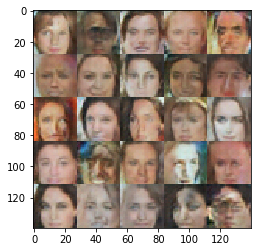

Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.3957... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.7952


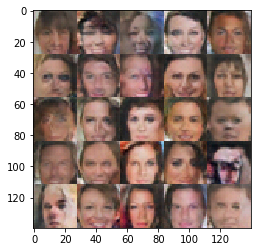

Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.8495


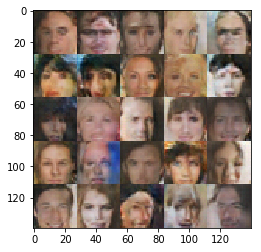

Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 1.4455... Generator Loss: 0.7159


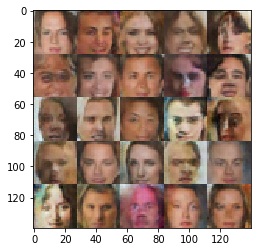

Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.8428
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.8176


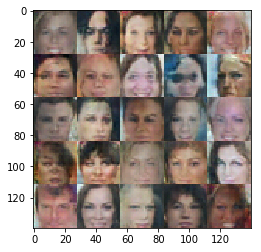

Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.3842... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.7463


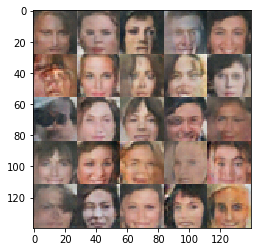

Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.3831... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.7874
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.4286... Generator Loss: 0.8060


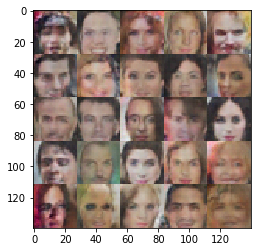

Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.7886
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.7778


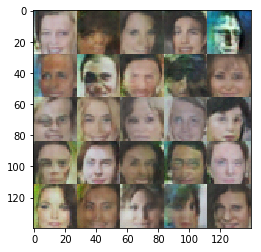

Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.7196
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.7576


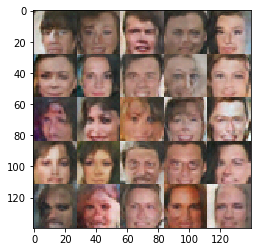

Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.7282


In [50]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.